In [5]:
import numpy as np
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

In [2]:
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [3]:
A = [0] * 10
A[0] = 1
A[1] = 1
A[-2] = 1
hallway = np.array(A)
print(hallway)

[1 1 0 0 0 0 0 0 1 0]


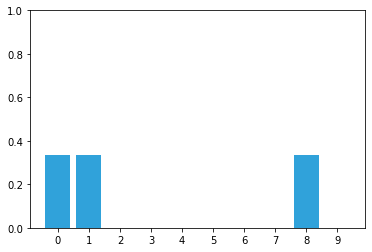

In [7]:
belief = hallway/3
book_plots.bar_plot(belief)